On 1-Dec-2020, the S&P500 (SPX) index value was 3662.45, while the SPDR
S&P500 Exchange Traded Fund (SPY) stock price was 366.02. The call and
put option prices (bid & offer) over 3 maturities are provided in the
spreadsheet:
• SPX options.csv
• SPY options.csv
The discount rate on this day is in the file: zero rates 20201201.csv.
Calibrate the following models to match the option prices:
1 Displaced-diffusion model
2 SABR model (fix β = 0.7)
Plot the fitted implied volatility smile against the market data.
Report the model parameters:
1 σ, β
2 α, ρ, ν
And discuss how does change β in the displaced-diffusion model and ρ, ν in the
SABR model affect the shape of the implied volatility

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq, least_squares
import matplotlib.pylab as plt
import math

First, we shall implement the SABR model. The implied Black volatility of the SABR model is given by

\begin{equation}
\sigma_{\text{SABR}}(F_0, K, \alpha, \beta, \rho, \nu) = \frac{\alpha}{(F_0K)^{(1-\beta)/2} \left\{ 1 + \frac{(1-\beta)^2}{24}\log^2\left(\frac{F_0}{K}\right) + \frac{(1-\beta)^4}{1920}\log^4\left(\frac{F_0}{K}\right) + \cdots \right\} } 
\cdot \frac{z}{x(z)} \cdot \left\{ 1 + \left[ \frac{(1-\beta)^2}{24} \frac{\alpha^2}{(F_0K)^{1-\beta}} + \frac{1}{4} \frac{\rho \beta \nu \alpha}{(F_0K)^{(1-\beta)/2}} + \frac{2-3\rho^2}{24}\nu^2 \right] T + \cdots \right\},
\notag
\end{equation}

where

\begin{equation}
z = \frac{\nu}{\alpha} (F_0K)^{(1-\beta)/2} \log\left(\frac{F_0}{K}\right), \notag
\end{equation}

and

\begin{equation}
x(z) = \log \left[ \frac{\sqrt{1-2\rho z+z^2} + z - \rho}{1 - \rho} \right]. \notag
\end{equation}


In [10]:
# functions for implied vol computation

def ddcalibration(x, option_prices, ATM_iv, strikes, r, F, T) -> float:
    """
    Function to obtain total squared error between estimated (using parameters in x) and actual price

    Parameters:
        x: list of DD parameters with sigma, beta
        strikes: K,
        vols: list of market implied volatility,
        F: stock future price adjusted for T or [S*np.exp(r*T)]
        T: years to expiry

    Return:
        total error computed from list of vol provided
    """
    err = 0.0
    
    for i, price in enumerate(option_prices):
        F_dd = F / x[0]
        K_dd = strikes[i] + (1 - x[0]) / x[0] * F 

        if strikes[i] > F:
            est_price = BlackCall(F_dd, K_dd, r, ATM_iv * x[0], T)
        else:
            est_price = BlackPut(F_dd, K_dd, r, ATM_iv * x[0], T)
        
        err += (price - est_price)**2
    
    return err

def preprocess_options_data(file_path):
    """
    Preprocess options data by calculating mid-price, scaling strike prices, 
    and mapping call/put flags.

    Parameters:
    - file_path (str): Path to the CSV file containing options data.

    Returns:
    - DataFrame: Processed options data with 'mid', 'strike', and 'payoff' columns.
    """
    df = pd.read_csv(file_path)
    df['mid'] = 0.5 * (df['best_bid'] + df['best_offer'])
    df['strike'] = df['strike_price'] * 0.001  # Adjusting strike price scale
    df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
    return df

def sabrcalibration(x, strikes, vols, F, T) -> float:
    """
    Function to obtain total squared error between estimated (using parameters in x) and actual given(vols) sigmas
    float

    Parameters:
        x: list of SABR parameters with alpha, rho, nu,
        strikes: K,
        vols: list of market implied volatility,
        F: stock future price adjusted for T or [S*np.exp(r*T)]
        T: years to expiry

    Return:
        total error computed from list of vol provided
    """
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2
    
    return err

def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol

def SABR(F, K, T, alpha, beta, rho, nu):
    """
    Use SABR model to return sigma 
    """

    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma


# functions for pricing functions
def BlackScholesLognormalCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def BlackScholesLognormalPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

def BlackCall(F, K, r, sig, T)->tuple:
    """
    Calculate the Black model prices of European call and put options.

    Parameters:
    ----------
    F0 : float
        Current futures price.
    K : float
        Strike price of the option.
    T : float
        Time to expiration in years.
    r : float
        Risk-free interest rate (as a decimal).
    sig : float
        Volatility of the underlying asset (annualized).

    Returns:
    -------
    tuple
        A tuple containing the call option price and the put option price (call_price, put_price).
    """
    d1 = (math.log(F/K) +.5*(sig**2)*T) / \
          (sig*T**.5)
    d2 = (math.log(F/K) -.5*(sig**2)*T) / \
          (sig*T**.5)
    
    return math.exp(-r*T) * ( F*norm.cdf( d1) - K *norm.cdf( d2) )

def BlackPut(F, K, r, sig, T)->tuple:
    """
    Calculate the Black model prices of European call and put options.

    Parameters:
    ----------
    F0 : float
        Current futures price.
    K : float
        Strike price of the option.
    T : float
        Time to expiration in years.
    r : float
        Risk-free interest rate (as a decimal).
    sig : float
        Volatility of the underlying asset (annualized).

    Returns:
    -------
    tuple
        A tuple containing the call option price and the put option price (call_price, put_price).
    """
    d1 = (math.log(F/K) +.5*(sig**2)*T) / \
          (sig*T**.5)
    d2 = (math.log(F/K) -.5*(sig**2)*T) / \
          (sig*T**.5)
    
    return math.exp(-r*T) * ( K *norm.cdf(-d2) - F*norm.cdf(-d1) )

def DisplacedDiffusionPrice(beta, ATM_iv, strikes, r, S, T) -> float:
    """
    Function to return prices of DD model

    Parameters:
        beta: dd beta
        strikes: K,
        vols: list of market implied volatility,
        S: stock spot px
        T: years to expiry

    Return:
        total error computed from list of vol provided
    """
    ls_price  = []
    F = S*np.exp(r*T)
    
    for strike in strikes:
        F_dd = F / beta
        K_dd = strike + ((1 - beta) / beta * F) 
        sig_dd = ATM_iv * beta

        if strike > S:
            est_price = BlackCall(F_dd, K_dd, r, sig_dd, T)
        else:
            est_price = BlackPut(F_dd, K_dd, r, sig_dd, T)
        
        ls_price.append(est_price)

    return ls_price


# functions execute calibration and plot exploratory graphs 
def calculate_displaced_diffusion_params(df, S, dict_ex_date_rate, impliedVolatility):
    dd_params = []

    for exdate, r in dict_ex_date_rate.items():
        # Filter for the current expiration date
        df_ex = df[df["exdate"] == exdate].copy()
        days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
        r = r/100
        T = days_to_expiry / 365
        F = S * np.exp(r * T)

        # Calculate Market implied volatilities
        df_ex['vols'] = df_ex.apply(lambda x: impliedVolatility(S, 
                                                                x['strike'], 
                                                                r, 
                                                                x['mid'], 
                                                                T, 
                                                                x['payoff']),
                                                                axis=1)
        df_ex.dropna(inplace=True)
        call_df = df_ex[df_ex['payoff'] == 'call']
        put_df = df_ex[df_ex['payoff'] == 'put']
        strikes = put_df['strike'].values
        impliedvols, option_prices, ls_payoff = [], [], []
        for K in strikes:    
            if K > S:
                impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
                option_prices.append(call_df[call_df['strike'] == K]['mid'].values[0])
                ls_payoff.append(call_df[call_df['strike'] == K]['payoff'].values[0])
            else:
                impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
                option_prices.append(put_df[put_df['strike'] == K]['mid'].values[0])
                ls_payoff.append(put_df[put_df['strike'] == K]['payoff'].values[0])

        df_iv = pd.DataFrame({'strike': strikes, 
                            'impliedvol': impliedvols,
                            'option_price': option_prices,
                            'payoff': ls_payoff})
        
        # finding ATM vol
        closest_strike = df_iv['strike'].iloc[(df_iv['strike'] - F).abs().idxmin()]
        spx_ATM_implied_vol = df_iv[df_iv['strike'] == closest_strike]['impliedvol'].values[0]

        # calibrate for optimal Beta
        # initialGuess = [.5]        # beta
        # res = least_squares(lambda x:ddcalibration(x, 
        #                                         option_prices, 
        #                                         spx_ATM_implied_vol,  
        #                                         strikes, 
        #                                         r,
        #                                         F, 
        #                                         T),
        #                     initialGuess,
        #                     bounds=(0,1))
        ls_beta = [1e-12,0.5,1]
        for dd_beta in ls_beta:
        # store results
            dd_prices = DisplacedDiffusionPrice(dd_beta, spx_ATM_implied_vol, strikes, r, S, T)
            df_iv['dd_prices'] = dd_prices
            df_iv[f'dd_vols_{dd_beta}'] = df_iv.apply(lambda x: impliedVolatility(S, 
                                                                        x['strike'], 
                                                                        r, 
                                                                        x['dd_prices'], 
                                                                        T, 
                                                                        x['payoff']),
                                                                        axis=1)
            dd_params.append({'exdate': exdate, 'dd_beta': dd_beta, 'sig_atm': spx_ATM_implied_vol, 'dd_vols': list(df_iv[f'dd_vols_{dd_beta}'])})
        # plot results
        colors = plt.cm.viridis(np.linspace(0, 1, len(ls_beta)))
        plt.figure(tight_layout=True)
        plt.title(f"{exdate} Market vs DD Implied Vol")
        plt.plot(strikes, df_iv['impliedvol'], 'gs', label='Market Implied Vols')
        for i, dd_beta in enumerate(ls_beta):
            plt.plot(strikes, df_iv[f'dd_vols_{dd_beta}'], linestyle='--', color=colors[i], label=f'DD Implied Vols, beta={dd_beta:.3f}')
        plt.legend()
        plt.show()

    for params in dd_params:
        print(f"Exdate {params['exdate']}: beta = {params['dd_beta']:.5f}, sigma = {params['sig_atm']:.5f}")

    return dd_params

def calculate_sabr_params(df, S, dict_ex_date_rate, impliedVolatility, sabrcalibration, SABR, beta=0.7):
    """
    Function to execute SABR parameter search based on option prices, rates, and beta.
    Prints out estimated SABR parameters for unique expiry dates in df

    Parameters:
        df: ticker data,
        df_rates: zero curve for annual vol with tenors in days column
        S: spot px
        impliedVolatility: function returning market implied vol
        SABR: function to return sigma for given parameters
        beta: fixed beta for SABR

    Return: 
        dictionary of SABR parameters and list of vols
    """
    # Initialize list to store SABR parameters for each expiration date
    sabr_params = []

    # Loop through each expiration date
    for exdate, r in dict_ex_date_rate.items():
        df_ex = df[df["exdate"] == exdate].copy()
        T = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days / 365
        r = r / 100
        F = S * np.exp(r * T)

        # Calculate implied volatilities
        df_ex['vols'] = df_ex.apply(lambda x: impliedVolatility(S, x['strike'], r, x['mid'], T, x['payoff']), axis=1)
        df_ex.dropna(inplace=True)

        # Filter and collect strikes and implied vols
        call_df, put_df = df_ex[df_ex['payoff'] == 'call'], df_ex[df_ex['payoff'] == 'put']
        strikes = put_df['strike'].values
        impliedvols = [
            call_df[call_df['strike'] == K]['vols'].values[0] 
                if K > S else put_df[put_df['strike'] == K]['vols'].values[0]
                    for K in strikes
        ]
        df_iv = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})
        
        # Calibrate SABR parameters
        initialGuess = [.02, .2, .1]
        res = least_squares(lambda x: sabrcalibration(x, df_iv['strike'], df_iv['impliedvol'], F, T), initialGuess)
        alpha, rho, nu = res.x
        
        # Plot SABR vs Market implied volatilities
        sabrvols = [SABR(F, K, T, alpha, beta, rho, nu) for K in strikes]
        sabr_params.append({'exdate': exdate, 'alpha': alpha, 'rho': rho, 'nu': nu, 'vols': sabrvols})
        plt.figure(tight_layout=True)
        plt.title(f"{exdate} Market vs SABR Implied Vol")
        plt.plot(strikes, df_iv['impliedvol'], 'gs', label='Market Implied Vols')
        plt.plot(strikes, sabrvols, 'm--', label='SABR Implied Vols')
        plt.legend()
        plt.show()
    
    # Output calibrated SABR parameters
    for params in sabr_params:
        print(f"Exdate {params['exdate']}: alpha = {params['alpha']:.3f}, rho = {params['rho']:.3f}, nu = {params['nu']:.3f}")

    return sabr_params

def plot_sabr_params(df, S, dict_ex_date_rate, impliedVolatility, sabrcalibration, SABR, beta=0.7):
    """
    Function to execute SABR parameter search based on SABR params, rates, and beta.
    Plots curves for varying rho and nu on separate graphs

    Parameters:
        df: ticker data,
        df_rates: zero curve for annual vol with tenors in days column
        S: spot px
        impliedVolatility: function returning market implied vol
        SABR: function to return sigma for given parameters
        beta: fixed beta for SABR

    Return: 
        dictionary of SABR parameters and list of vols
    """
    exdate = 20210115
    r = dict_ex_date_rate[exdate]
    sabr_params = []

    df_ex = df[df["exdate"] == exdate].copy()
    T = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days / 365
    r = r / 100
    F = S * np.exp(r * T)

    # Calculate implied volatilities
    df_ex['vols'] = df_ex.apply(lambda x: impliedVolatility(S, x['strike'], r, x['mid'], T, x['payoff']), axis=1)
    df_ex.dropna(inplace=True)

    # Filter and collect strikes and implied vols
    call_df, put_df = df_ex[df_ex['payoff'] == 'call'], df_ex[df_ex['payoff'] == 'put']
    strikes = put_df['strike'].values
    impliedvols = [
        call_df[call_df['strike'] == K]['vols'].values[0] 
            if K > S else put_df[put_df['strike'] == K]['vols'].values[0]
                for K in strikes
    ]
    df_iv = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})
    
    # Calibrate SABR parameters
    initialGuess = [.02, .2, .1]
    res = least_squares(lambda x: sabrcalibration(x, df_iv['strike'], df_iv['impliedvol'], F, T), initialGuess)
    alpha, rho, nu = res.x
    
    # get base line plot
    sabrvols = [SABR(F, K, T, alpha, beta, rho, nu) for K in strikes]
    sabr_params.append({'exdate': exdate, 'alpha': alpha, 'rho': rho, 'nu': nu, 'vols': sabrvols})
    ls_rho = [-.5, 0, .5]
    ls_nu = [nu*.8, nu*1.2, nu*1.4]

    for dummy_rho in ls_rho:
        sabrvols = [SABR(F, K, T, alpha, beta, dummy_rho, nu) for K in strikes]
        sabr_params.append({'exdate': exdate, 'alpha': alpha, 'rho': dummy_rho, 'nu': nu, 'vols': sabrvols})
    
    for dummy_nu in ls_nu:
        sabrvols = [SABR(F, K, T, alpha, beta, rho, dummy_nu) for K in strikes]
        sabr_params.append({'exdate': exdate, 'alpha': alpha, 'rho': rho, 'nu': dummy_nu, 'vols': sabrvols})

    colors = plt.cm.viridis(np.linspace(0, 1, len(ls_rho)+len(ls_nu)+1))
    plt.figure(tight_layout=True)
    plt.title(f"{exdate} Market vs SABR Implied Vol")
    plt.plot(strikes, df_iv['impliedvol'], 'gs', label='Market Implied Vols')
    for i, params in enumerate(sabr_params):
        if params['nu'] not in ls_nu:
            plt.plot(strikes, params['vols'], 'm--', color=colors[i], label=f"SABR Implied Vols rho = {params['rho']:.5f}")
    plt.legend()
    plt.show()
    
    plt.figure(tight_layout=True)
    plt.title(f"{exdate} Market vs SABR Implied Vol")
    plt.plot(strikes, df_iv['impliedvol'], 'gs', label='Market Implied Vols')
    for i, params in enumerate(sabr_params):
        if params['rho'] not in ls_rho:
            plt.plot(strikes, params['vols'], 'm--', color=colors[i % len(colors)], label=f"SABR Implied Vols nu = {params['nu']:.5f}")
            # plt.plot(strikes, params['vols'], 'm--', label=f"SABR Implied Vols nu = {params['nu']}")
    plt.legend()
    plt.show()

## SABR functions and constants
beta = 0.7 # config for SABR modelbeta = 0.7 # config for SABR model
S_spx = 3662.45
S_spy = 366.02

In [11]:
# get market prices and prepare data
df_rates = pd.read_csv("zero_rates_20201201.csv")\
            .sort_values('days')

df_spx = preprocess_options_data("SPX_options.csv")
df_spy = preprocess_options_data("SPY_options.csv")

# rates data
exdates = sorted(df_spx['exdate'].unique())[:3].copy()
days_to_expiry = [(pd.Timestamp(str(date)) - pd.Timestamp('2020-12-01')).days \
                    for date in exdates]
arr_rates = np.interp(
                        days_to_expiry,df_rates['days'].values, 
                        df_rates['rate'].values,
                    )
dict_ex_date_rate = dict(zip(exdates, arr_rates))

# Displaced-Diffusion Model
## SPX

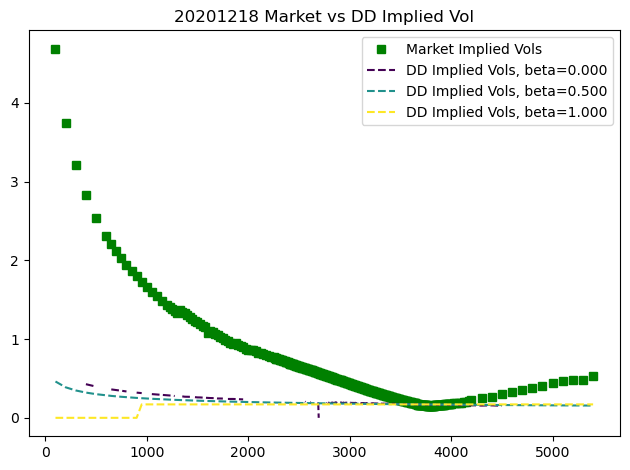

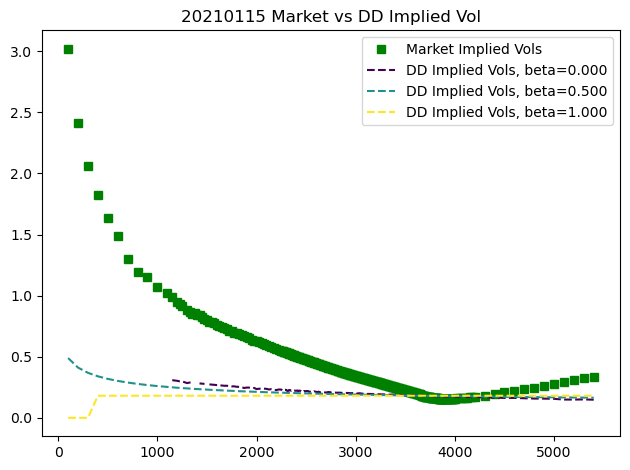

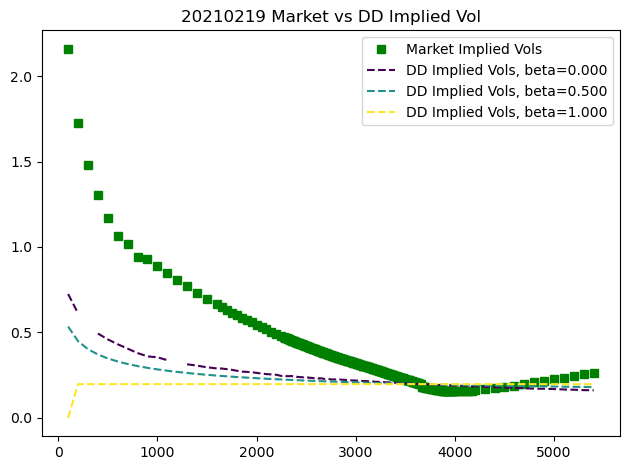

Exdate 20201218: beta = 0.00000, sigma = 0.17060
Exdate 20201218: beta = 0.50000, sigma = 0.17060
Exdate 20201218: beta = 1.00000, sigma = 0.17060
Exdate 20210115: beta = 0.00000, sigma = 0.18080
Exdate 20210115: beta = 0.50000, sigma = 0.18080
Exdate 20210115: beta = 1.00000, sigma = 0.18080
Exdate 20210219: beta = 0.00000, sigma = 0.19717
Exdate 20210219: beta = 0.50000, sigma = 0.19717
Exdate 20210219: beta = 1.00000, sigma = 0.19717


In [12]:
calculate_displaced_diffusion_params(df_spx, S_spx, dict_ex_date_rate, impliedVolatility);

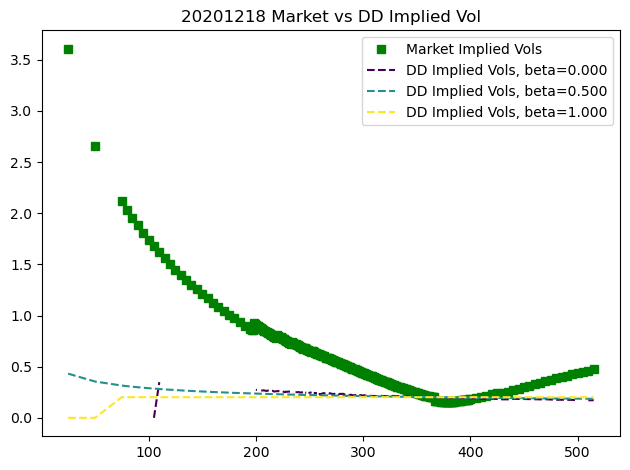

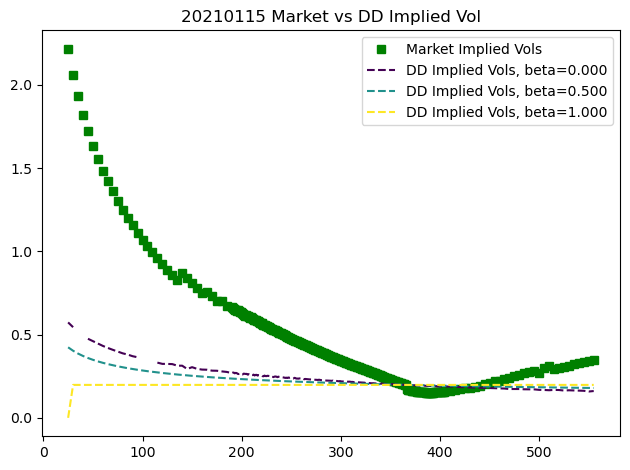

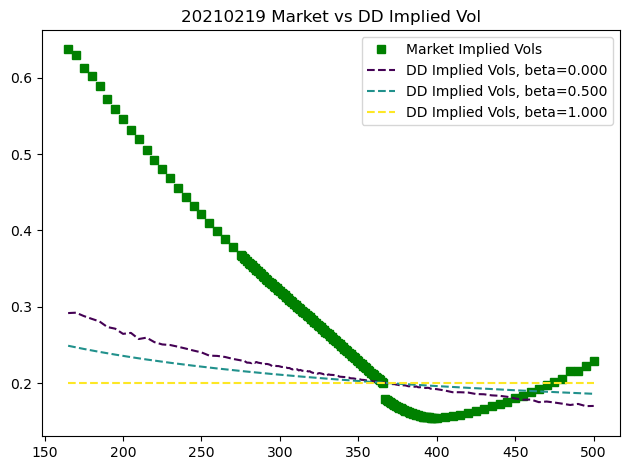

Exdate 20201218: beta = 0.00000, sigma = 0.20155
Exdate 20201218: beta = 0.50000, sigma = 0.20155
Exdate 20201218: beta = 1.00000, sigma = 0.20155
Exdate 20210115: beta = 0.00000, sigma = 0.19777
Exdate 20210115: beta = 0.50000, sigma = 0.19777
Exdate 20210115: beta = 1.00000, sigma = 0.19777
Exdate 20210219: beta = 0.00000, sigma = 0.20065
Exdate 20210219: beta = 0.50000, sigma = 0.20065
Exdate 20210219: beta = 1.00000, sigma = 0.20065


In [13]:
calculate_displaced_diffusion_params(df_spy, S_spy, dict_ex_date_rate, impliedVolatility);

# SABR model

## SPX

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_14533/2462095948.py:103: RuntimeWarning: invalid value encountered in double_scalars
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_14533/2462095948.py:103: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


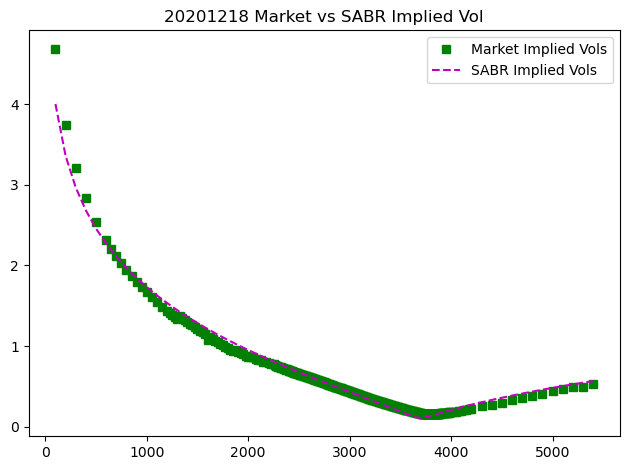

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_14533/2462095948.py:103: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_14533/2462095948.py:103: RuntimeWarning: invalid value encountered in double_scalars
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


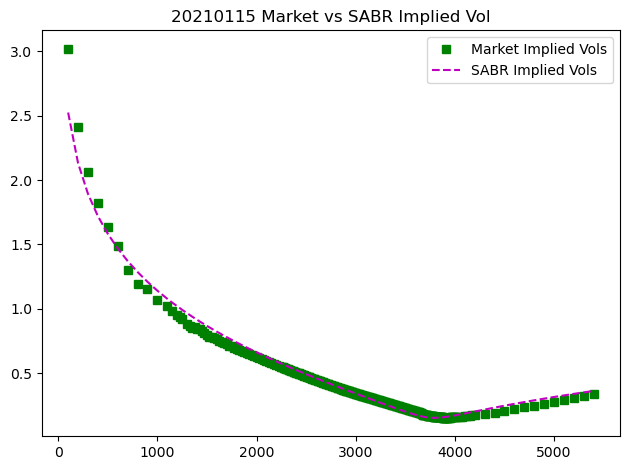

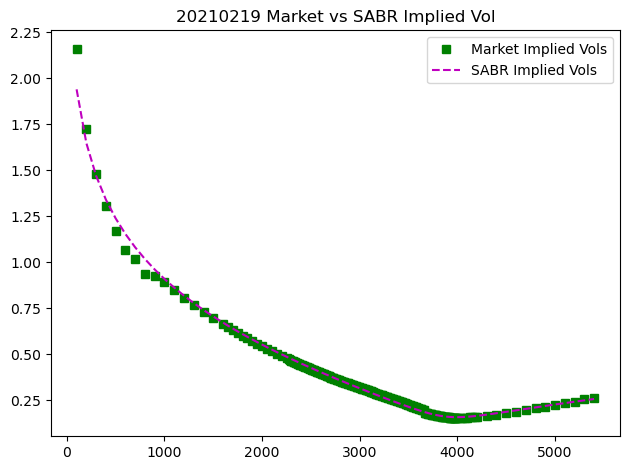

Exdate 20201218: alpha = 1.212, rho = -0.301, nu = 5.460
Exdate 20210115: alpha = 1.817, rho = -0.404, nu = 2.790
Exdate 20210219: alpha = 2.140, rho = -0.575, nu = 1.842


In [14]:
calculate_sabr_params(df_spx, S_spx, dict_ex_date_rate, impliedVolatility, sabrcalibration, SABR, beta=0.7);

## SPY

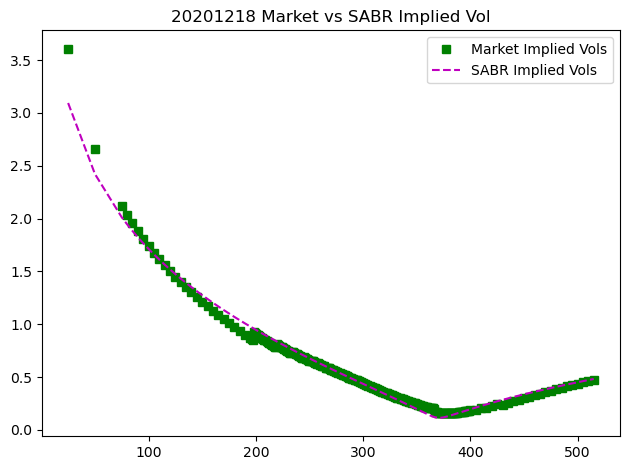

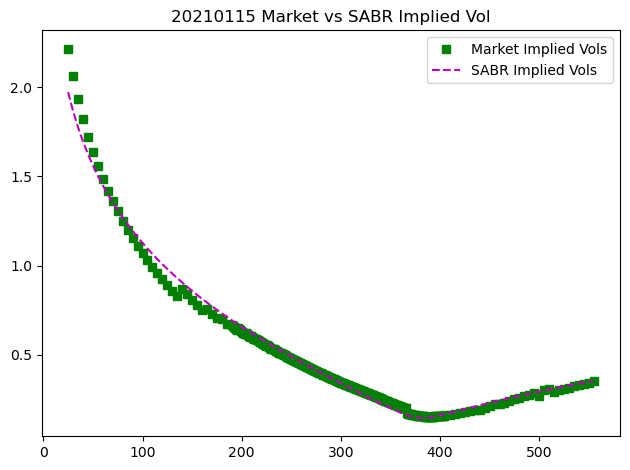

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_14533/2462095948.py:103: RuntimeWarning: invalid value encountered in double_scalars
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


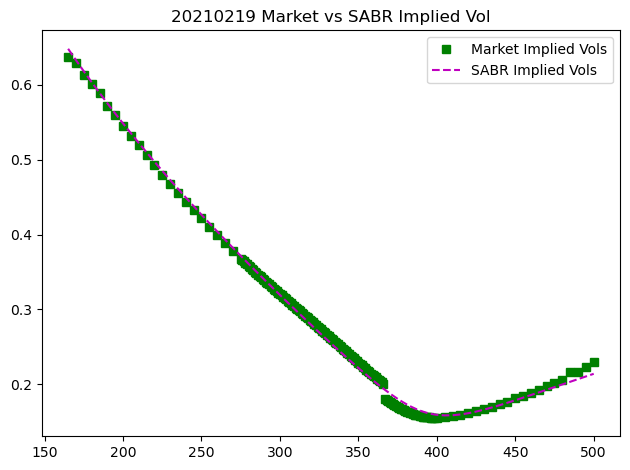

Exdate 20201218: alpha = 0.665, rho = -0.412, nu = 5.250
Exdate 20210115: alpha = 0.908, rho = -0.489, nu = 2.729
Exdate 20210219: alpha = 1.121, rho = -0.633, nu = 1.742


In [15]:
calculate_sabr_params(df_spy, S_spy, dict_ex_date_rate, impliedVolatility, sabrcalibration, SABR, beta=0.7);

### SABR Compare changing params
#### comparing $\rho$
• The correlation parameter ρ is proportional to the skewness of stock
returns. \
• Intuitively, a negative correlation results in high volatility when the stock
price drops, and this spreads the left tail of the probability density. The
right tail is associated with low volatility and is not spread out. \
• A negative correlation creates a fat left tail and a thin right tail in the
stock return distribution \
• This increases the prices of out-of-the-money puts and decreases the
prices of out-of-the-money calls relative to the Black-Scholes model price.
• Intuitively, out-of-the-money put options benefit substantially from a fat
left tail. \
• A positive correlation will have completely opposite effects—it creates a
fat right tail and a thin left tail. \
• $\rho = [-1,1]$ 

Plot below is $\rho$ at optimised, -0.5 and 0.5 $\rho = -0.5$ has higher values than $\rho = 0.5$ at low strike and lower values at high strikes.

#### comparing $\nu$
• When the volatility of volatility parameter is 0, we are back to a normal
log-return distribution (if β = 0). \
• Otherwise, it increases the kurtosis of stock returns, creating two
fat tails in both ends of the distribution. \
• This has the effect of raising out-of-the-money puts and
out-of-the-money call prices. \

• If volatility is uncorrelated with stock return, then increasing the volatility
of volatility only increases the kurtosis of spot return. \
• In this case, random volatility is associated with increases in the prices of
far-from-the-money options relative to near-the-money options. \
• In contrast, the correlation of volatility with the spot return produces
skewness. \

• $\nu = [0,\infty]$ 

Plot below is various $\nu$, all other pricing variables held constant and plot SABR vol. $\nu = 2.8$ has lower values than $\nu = 3.9$ at all strikes.

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_14533/2462095948.py:103: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_14533/2462095948.py:103: RuntimeWarning: invalid value encountered in double_scalars
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_14533/2462095948.py:425: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "m--" (-> color='m'). The keyword argument will take precedence.
  plt.plot(strikes, params['vols'], 'm--', color=colors[i], label=f"SABR Implied Vols rho = {params['rho']:.5f}")


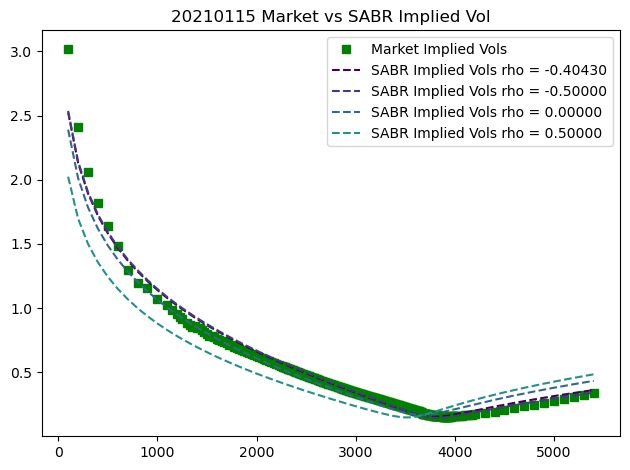

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_14533/2462095948.py:434: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "m--" (-> color='m'). The keyword argument will take precedence.
  plt.plot(strikes, params['vols'], 'm--', color=colors[i % len(colors)], label=f"SABR Implied Vols nu = {params['nu']:.5f}")


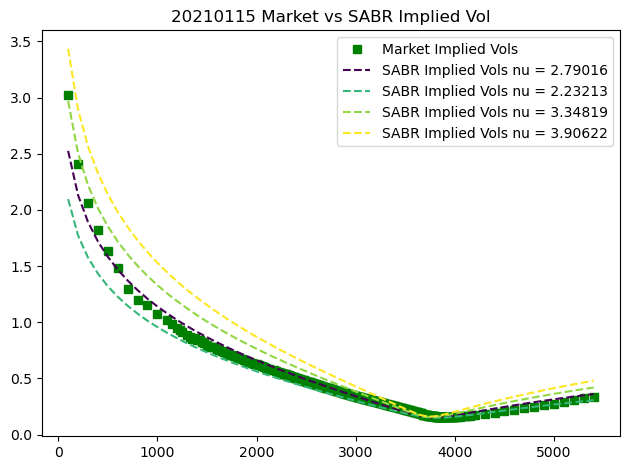

In [16]:
plot_sabr_params(df_spx, S_spx, dict_ex_date_rate, impliedVolatility, sabrcalibration, SABR, beta=0.7)